In [1]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import acquire
import prepare
import explore
import model

import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
# pandas display preferences
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
pd.set_option('display.precision', 3)

############
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn as sk

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# Project Overview

#### We will conduct an in depth analysis of customer data for the hypothetical telecommunications company, TelCo. We will use exploratory analysis techniques to identify the key drivers of customer churn, then use machine learning algorithms to create a model capable of predicting whether or not a customer will churn.

# Project Description

#### Telco aims to provide an excellent product at a fair price, and to maximize customer satisfaction at every opportunity. A key metric of success in these goals is the customer churn rate. To date, Telco customers have been leaving the company at an unacceptable rate. To maintain the company's reputation as the best in the business, we need to do something about this. 

#### We will analyze the attributes of customers who have been more or less likely to churn, develop a model for predicting churn based on those atributes, and leave with both recommendations for future passengers and predictions of churn for a list of current customers (delivered via .csv)

# Project Goals

#### By identifying key drivers of customer churn and creating a predictive model, the company can focus resources on those customers most likey to churn, proactively engaging them in ways that make them more likely to continue using Telco services.

# Acquire

In this stage, we use a SQL query to access the Codeup MySQL database and joined together all the relevant data using the following tables:
- customers
- contract_types
- internet_service_types
- payment_types

The code to access the database and obtain this data is encapsulated in get_telco_data function in the acquire module.

In [2]:
# utilize the get_telco_data() function from the acquire module to create a dataframe of customer data
df = acquire.get_telco_data()

Reading from local CSV...


# Prepare

In this stage, we clean and prepare the data for further exploration and modeling and encapsulated the relevant code in the prepare module.

The prep_telco_1 function accomplishes the following: 
- drops any duplicate rows that may be present, so as not to count a customer twice
- fixes a formatting issue in the total_charges column
- removes customers with a 0 value for tenure (brand new customers who have not had an opportunity to churn are not relevant to our study)
    - note: this also removed rows with missing values in the total_charges column
        - (there were no other missing values in the dataset)
- drops unnecessary or unhelpful columns which can provide no additional predictive value, including:
    - payment_type_id
    - internet_service_type_id
    - contract_type id
    - customer_id
    - total_charges (because it is merely a function of monthly charges and tenure)
- changes values in the senior_citizen column to Yes/No instead of 1/0 for readability
- creates new features, including: 
    - tenure_quarters, which represents which quarter of service a customer is currently in (or was in at the time of churn). 
    - tenure_years, which represents which year of service a customer is currently in (or was in at the time of churn). 

The prep_telco_2 function accomplishes the following:

- encodes categorical variables into machine-readable 1's and 0's

In [3]:
# use the prep_telco_1 function from the prepare module to clean and prep the dataframe
df = prepare.prep_telco_1(df)

In [4]:
# use the prep_telco_2 function from the prepare module to clean and prep the dataframe
df = prepare.prep_telco_2(df)

Here we split the sample into three distinct samples:

- `train`
    - we explore the data and train our machine learning models using this sample
- `validate`
    - we then evaluate the model's performance on data with which it was not trained, using this sample
- `test`
    - once we have chosen the model with the best performance, we conduct one final test on this sample to simulate how the model might perform on new data once it is placed into production



The `train_test_validate_split` function from the prepare module accomplishes all of this. The number of records in each sample can be seen below.


In [5]:
# define target variable
target = 'churn'

# utilizing the function defined in prepare.py, split the data into train, test, and validate samples
train, test, validate = prepare.train_test_validate_split(df, target)

train	 n = 3937
test	 n = 1407
validate n = 1688


# Explore

In this stage, we use data visualization techniques to get a good overall understaning of our data, as well as to help answer some specific questions. 

### Exploring Overall Churn

Below, we can see the context of the problem: an overall customer churn rate of 27%

The `plot_overall_churn` function from the `explore` module displays the pie chart below.

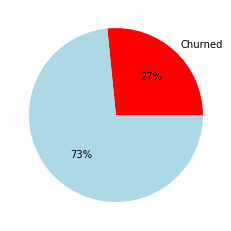

In [6]:
# use the plot_overall_churn_function to display a matplotlib pie chart of percentage of customers churned
explore.plot_overall_churn(df)

### Initial Exploration

In the initial exploration stage, we used data visualization techniques to explore the distributions of and relations among all features in the dataset. This helped us get a feel for who are customers are and what serices they use. For brevity, those visualizations are not included here. 

### Exploring Correlation

Next we explore how each of the variables correlates with whether a customer has churned. For this exploration, we have used the encoded (1's and 0's) version of our categorical variables. 

While correlation values between categorical values are not the most statistically sound metrics, this helps us get a basic understanding of how much each variable relates to our target, and provides a jumping off point for further exploration. We will look at the absolute value of the correlation to identify strength of relationship, ignoring whether that relationship is positive or negative. 

The `multivar_absolute_correlations` function from the `explore` module uses the `train` sample to produce the correlation chart shown below. 

In [11]:
# use the multivar_absolute_correlations function to create an ordered chart of the absolute correlation of each 
#    encoded variable with the encoded target variable
explore.multivar_absolute_correlations(train)

,enc_churn
enc_churn,1.000
tenure_months,0.361
tenure_quarters,0.359
tenure_years,0.348
enc_payment_type_electronic check,0.328
enc_internet_service_type_fiber optic,0.310
enc_contract_type_two year,0.301
enc_internet_service_type_none,0.230
enc_streaming_movies_no internet service,0.230
enc_streaming_tv_no internet service,0.230


We can see that tenure, payment type, internet service type, and contract type, appear to be most closely tied to the churn rate. We therefore expect that these features will usually be more predicitve of churn in the modeling stage than other features. We will explore a few of them in more depth below. 

Though demographic information such as gender, senior citizen status, and family size (partner/dependants) don't appear high on the correlation list, we will also conduct some additional analysis of those features, since we expect that a marketing team may be able to more effectively create customer incentives targeted at sepecific demographics. 

### Further Exploration - Does demographic information affect churn?

#### Do males or females churn at a higher rate than expected?

i.e. Is churn independent of gender?

the `churn_rate_by_gender` function from the `explore` module creates the chart shown below. 

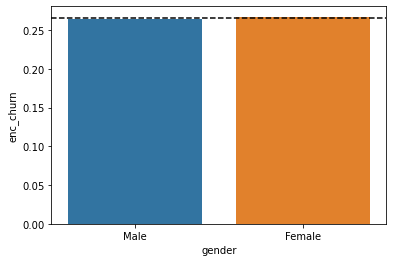

In [12]:
# call the churn_rate_by_gender function on the train sample to create a seaborn barplot of churn rate by gender 
explore.churn_rate_by_gender(train)

Here we can see that both genders appear to churn at a rate that is close to average (represented by the dashed line). However, we will do some statistical testing just to be sure.

Establish Hypotheses:

H0: Whether a customer has churned is independent of their gender

H1: Whether a customer has churned is not independent of their gender

The `chi2_test` function from the `explore` module runs a statistical test to determine the likelihood that the differences we see between the observed and expected values of gender versus churn might occur by chance. 

In [13]:
# use the chi2_test function from the explore module to conduct a chi^2 test for independence on churn and gender
#     display observed and expected frequency tables, test statistic, and p value. Test p-value against alpha and
#     display whether to reject the null hypothesis. 
explore.chi2_test(train.churn, train.gender)

Observed

[[1429 1462]
 [ 521  525]]
---
Expected

[[1431.9 1459.1]
 [ 518.1  527.9]]
---

chi^2 = 0.0304
p     = 0.8616

Fail to Reject H0


The p-value of .8616 indicates that there is roughly an 86% percent probability that any difference in churn rate between male and female would have occurred by chance. With this in mind, we fail to reject the null hypothesis, and we proceed under the assumption that whether a customer has churned is independent of their gender. 

This tells us that gender is unlikely to be a useful as a predictive feature in our model. 

#### Do senior citizens churn at a rate that is different than expected?

i.e. Is churn independent of senior citizen status?

The `churn_rate_by_senior` function from the `explore` module displays the chart below.

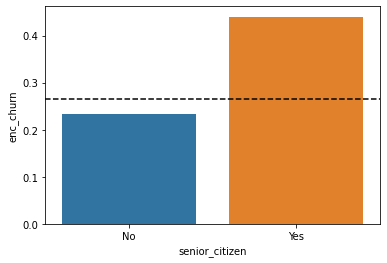

In [14]:
# call the churn_rate_by_senior function on the train sample to display a seaborn barplot of churn rate by senior citizen status
explore.churn_rate_by_senior(train)

We can see that senior_citizens appear to churn at a much higher rate than average. But how likely is it that this difference might occur by chance? We will conduct a statistical test to find out. 

Establish hypotheses: 
    
H0: Whether a customer has churned is independent of whether they are a senior citizen
    
H1: Whether a customer has churned is not independent of whether they are a senior citizen

The `chi2_test` function from the `explore` module runs a statistical test to determine the likelihood that the differences we see between the observed and expected values of senior_citizen versus churn might occur by chance. 



In [15]:
# use the chi2_test function from the explore module to conduct a chi^2 test for independence on churn and senior_citizen
#     display observed and expected frequency tables, test statistic, and p value. Test p-value against alpha and
#     display whether to reject the null hypothesis. explore.chi2_test(train.churn, train.senior_citizen)

The p-value of 0.0000 indicates that there is virtually a 0 percent probability that these differences would occur by chance. With this in mind, wereject the null hypothesis, and we proceed under the assumption that a customer's senior citizen status is not independent of whether they have churned. 

This tells us that senior_citizen may be a useful predictive feature in our model.

#### Do customers with or without partners churn at a rate that is different than expected?
i.e. Is churn independent of whether a customer has a partner?

The `churn_rate_by_partner` function from the `explore` module creates the chart below.

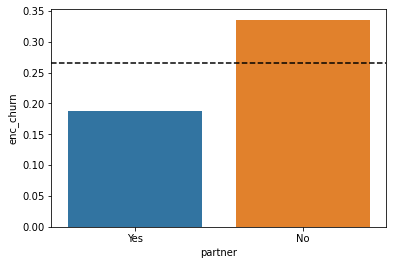

In [16]:
explore.churn_rate_by_partner(train)

Here we can see that single customers - those without partners - appear to churn at a higher rate. However, how likely is this to have occurred by chance? We will conduct a statistical test to find out. 

Establish hypotheses:

H0: Whether a customer has churned is independent of whether they have a partner
    
H1: Whether a customer has churned is not independent of whether they have a partner
    
The `chi2_test` function from the `explore` module runs a statistical test to determine the likelihood that the differences we see between the observed and expected values of partner versus churn might occur by chance. 

In [17]:
# use the chi2_test function from the explore module to conduct a chi^2 test for independence on churn and partner.
#     display observed and expected frequency tables, test statistic, and p value. Test p-value against alpha and
#     display whether to reject the null hypothesis. 
explore.chi2_test(train.churn, train.partner)

Observed

[[1373 1518]
 [ 694  352]]
---
Expected

[[1517.8 1373.2]
 [ 549.2  496.8]]
---

chi^2 = 108.7547
p     = 0.0000

Reject H0


The p-value of 0.0000 indicates that there is virtually a 0 percent probability that these differences would occur by chance. With this in mind, wereject the null hypothesis, and we proceed under the assumption that whether a customer has a partner is not independent of whether they have churned. 

This tells us that a customers partner status may increase their likelihood of churn, and may be a useful predictive feature in our model.

#### Do customers with or without dependents churn at a rate that is different than expected. ?

i.e. Is churn independent of whether a customer has dependents?

The `churn_rate_by_dependents` function creates the chart shown below.

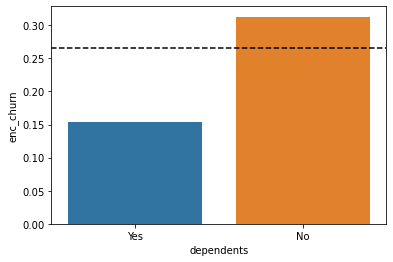

In [18]:
explore.churn_rate_by_dependents(train)

Here we can see that those without dependents appear to churn at a higher rate than average, while those with dependents churn at a lower rate. How likely is it that this difference might occur by chance? We will conduct a statistical test to find out. 

Establish hypotheses

H0: Whether a customer has churned is independent of whether they have dependents

H1: Whether a customer has churned is not independent of whether they have dependents
    
The `chi2_test` function from the `explore` module runs a statistical test to determine the likelihood that the differences we see between the observed and expected values of dependants versus churn might occur by chance. 

In [19]:
# use the chi2_test function from the explore module to conduct a chi^2 test for independence on churn and dependants
#     display observed and expected frequency tables, test statistic, and p value. Test p-value against alpha and
#     display whether to reject the null hypothesis. 
explore.chi2_test(train.churn, train.dependents)

Observed

[[1899  992]
 [ 865  181]]
---
Expected

[[2029.6  861.4]
 [ 734.4  311.6]]
---

chi^2 = 105.4278
p     = 0.0000

Reject H0


The p-value of 0.0000 indicates that there is virtually a 0 percent probability that these differences would occur by chance. With this in mind, wereject the null hypothesis, and we proceed under the assumption that whether a customer has dependants is not independent of whether they have churned. 

This indicates that a customer not having dependents may increase their likelihood of churn, and that dependents may be a useful predictive feature in our model. 

### Further Exploration - Do customers who churn have higher average monthly charges than those who don't?

The `monthly_charges_by_churn` function creates the chart shown below. 

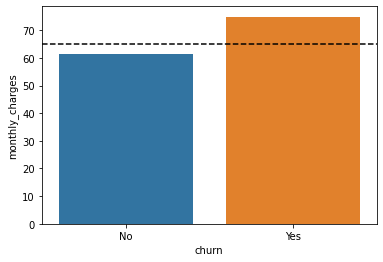

In [20]:
explore.monthly_charges_by_churn(train)

We can see that customers who have churned tend to have higher average monthly charges than those who haven't. We will conduct a statistical test to determine whether this difference is likely to occur by chance. 

Establish hypotheses

H0: Average monthly charges is the same for customers who have churned and those who have not

H1: Average monthly charges are higher for customers who have churned than for those who have not

The `hypothesis_test_monthly_charges` function from the `explore` module runs a statistical test to determine the likelihood that the difference that we see between mean monthly charges for customers who have churned and those who have not might occur by chance. 

In [21]:
# use the hypothesis_test_monthly_charges function from the eplore module to conduct a Mann-Whitney U test
#    to compare mean monthly charges for churn customers vs not churn customers. Display the test statistic and the p-value. 
explore.hypothesis_test_monthly_charges(train)

MANN-WHITNEY U TEST FOR: MONTHLY_CHARGES

u = 1885392.5
p = 0.0



The p-value of 0.0000 indicates that there is virtually a 0 percent probability that this difference would occur by chance. With this in mind, we reject the null hypothesis, and we proceed under the assumption that customers who have churned have higher average monthly charges than those who did not churn.

This tells us that higher monthly charges may increase the probability of churn, and that monthly_charges may prove to be a useful predictive feature in our model. 

### Further Exploration - What month (or range of months) are customers most likely to churn?

The `when_customers_churn` function from the `explore` module uses the `train` sample to create the charts and visualizations shown below. 

TENURE_MONTHS


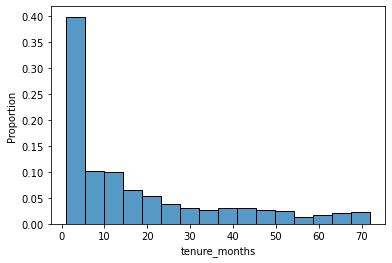

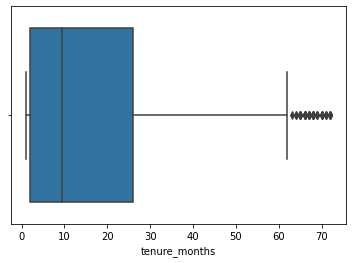

       tenure_months
count       1046.000
mean          17.433
std           19.213
min            1.000
25%            2.000
50%            9.500
75%           26.000
max           72.000
mode:		 1
TENURE_QUARTERS


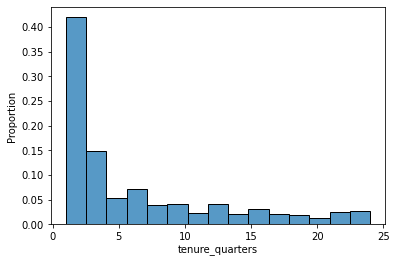

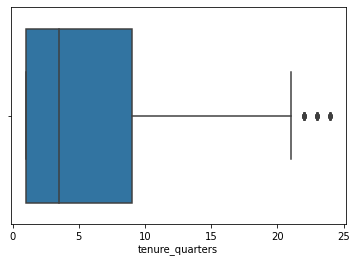

       tenure_quarters
count         1046.000
mean             6.207
std              6.363
min              1.000
25%              1.000
50%              3.500
75%              9.000
max             24.000
mode:		 1
TENURE_YEARS


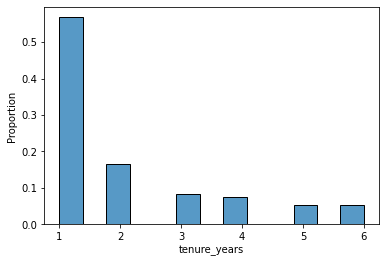

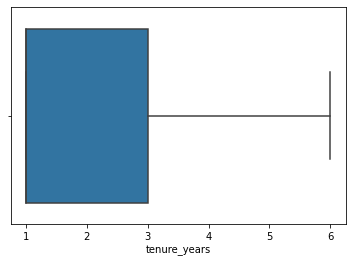

       tenure_years
count      1046.000
mean          2.038
std           1.509
min           1.000
25%           1.000
50%           1.000
75%           3.000
max           6.000
mode:		 1


In [22]:
# use the when_customers_churn function from the explore module to display histograms, boxplots, 
#      and summary statistics for distributions of tenure_months, tenure_quarters, and tenure_years 
#      for customers who have churned. 
explore.when_customers_churn(train)

Customers churn most often in their first month, and on average in their 17th month.

Customers churn most often in their first quarter, and on average in their 6th quarter

Customers churn most often in their first year, and on average in their 2nd year. 

The bulk of customers (75%) churn within their first three years. 

### Further Exploration - What month are customers most likely to churn - by contract type

When we control for contract type, we see a marked difference in the typical time period a customer churns for month-to-month customers versus the other contract types. 

The `when_customers_churn_by_contract_type` function from the `explore` module creates the charts and visualizations shown below. 

One year


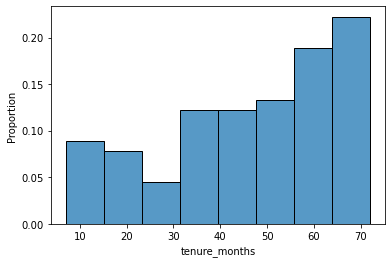

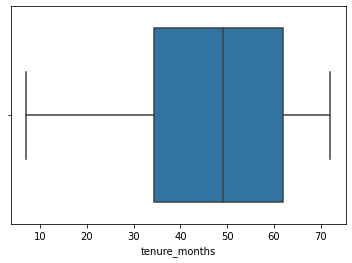

       tenure_months
count         90.000
mean          46.389
std           18.304
min            7.000
25%           34.250
50%           49.000
75%           62.000
max           72.000
mode:		 56
Two year


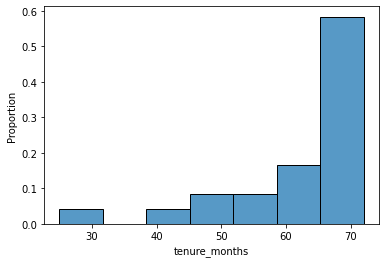

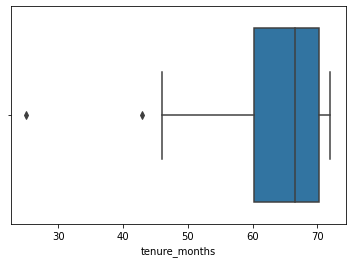

       tenure_months
count         24.000
mean          62.583
std           11.515
min           25.000
25%           60.250
50%           66.500
75%           70.250
max           72.000
mode:		 71
Month-to-month


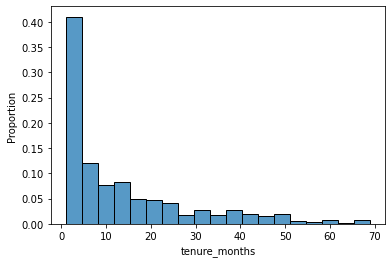

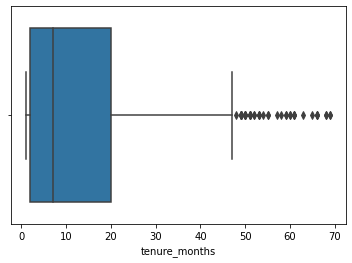

       tenure_months
count        932.000
mean          13.474
std           15.157
min            1.000
25%            2.000
50%            7.000
75%           20.000
max           69.000
mode:		 1


In [23]:
# use when_customers_churn_by_contract_type function from the explore module to display histograms, boxplots, 
#     and summary statistics of tenure months for customers who have churned with each category of contract type
explore.when_customers_churn_by_contract_type(train)

Here we can see that the distribution of tenure varies significantly between those with monthly contract and those with other contract types. Monthly customers, who we know are most likely to churn, also churn much earlier than their longer-contract counterparts. This should not be surprising, but it is worth noting. 

The average month in which monthly customers churn is their 13th month (while the most common is the 1st month). 

For yearly and two-year contract customers, the average is the 46th and 62nd month, respectively (most common is 56 and 71). 

### Further Exploration: is there an internet service type associated with more or less churn than expected?
i.e. is the churn rate different for any particular service type vs the overall average?

The `churn_by_int_service_type` function from the `explore` module produces the visualization shown below. 

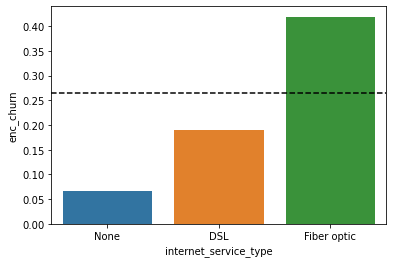

In [24]:
# use the churn_by_int_service_type function from the explore module to produce a seaborn barplot of churn rate for each category of internet service type
     # add a horizontal line representing the overall average churn rate
explore.churn_by_int_service_type(train)

We can see that customers with Fiber Optic internet service churn at a rate that is much higher than the overall average (represented by the dashed line). 

But does this difference occur by chance?

#### Is whether a customer has churned independent of their internet service type?

Establish hypotheses

H0: Whether a customer has churned is independent of their internet service type

H1: Whether a customer has churned is not independent of their internet service type

The `chi2_test` function from the `explore` module runs a statistical test to determine the likelihood that the differences we see between the observed and expected values of internet service type versus churn might occur by chance. 

In [25]:
# use the chi2_test function from the explore module to conduct a chi^2 test for independence on churn and internet service type.
#     display observed and expected frequency tables, test statistic, and p value. Test p-value against alpha and
#     display whether to reject the null hypothesis. 
explore.chi2_test(train.churn, train.internet_service_type)

Observed

[[1114 1013  764]
 [ 260  731   55]]
---
Expected

[[1008.9 1280.6  601.4]
 [ 365.1  463.4  217.6]]
---

chi^2 = 417.1612
p     = 0.0000

Reject H0


The p-value of 0.0000 indicates that there is virtually a 0 percent probability that these differences would occur by chance. With this in mind, we reject the null hypothesis, and we proceed under the assumption that whether a customer has churned is not independent of their internet service type. 

## Exploration Summary

We found the following features seem to affect the likelihood of churn:

- senior_citizen
- partner 
- dependents
- monthly charges
- tenure (i.e. tenure_months, tenure_quarters, tenure_years)

While the gender feature did not seem to affect the likelihood of churn. 

While we may still test models with all available features, we expect that models that include features correlated with churn while excluding those that aren't will be more effective. 

# MODELING

Here we will use various machine learning algorithms to create models that predict with a certain level of accuracy whether or not a customer will churn. 

The code in the cells below establishes the infrastructure necessary for storing displaying information about each model that is created and evaluated.  

In [26]:
# identify the target variable for modeling
target = 'enc_churn'
# identify which value of the target value will be considered the positive case
positive = 1

In [27]:
# create empty dataframe to store model results
model_results = pd.DataFrame(columns=['model_number', 'metric_type', 'sample_type', 'score'])

# create empty dataframe to store metadata about each model
model_info = pd.DataFrame(columns=['model_number', 'features'])

The following code identifies the various combinations of features (i.e. pieces of information about the customers) that will be fed into the model for making predictions.

We will first use a list of all possible features, then narrow that down into a list of features that our previous exploration showed as being relevant to customer churn:
- senior_citizen
- partner
- dependants
- contract_type
- internet_service_type


In [29]:
# identify a feature set that includes all possible features
encoded_columns = [col for col in df.columns if (col[:4] == 'enc_') and col != target]
features1 = encoded_columns

# identify an additional feature set
features2 = ['enc_senior_citizen_yes', 
             'enc_partner_yes', 
             'enc_dependents_yes', 
             'enc_contract_type_one year', 'enc_contract_type_two year', 
             'enc_internet_service_type_fiber optic', 'enc_internet_service_type_none']

# create a list of feature sets to iterate over
feature_combos = [features1, features2]

### Baseline

Next, we will establish our baseline predictions. This represents what would happen if we simply always predicted the thing that is most likely to happen. I.e., since more customers have churned than not, how accurate would our model be if it simply always predicted that a customer would churn.

Information about the baseline model is stored for later evaluation and visualization.

In [30]:
# separate each sample into x (features) and y (target)
x_train = train.drop(columns=target)
y_train = train[target]

x_validate = validate.drop(columns=target)
y_validate = validate[target]

x_test = test.drop(columns=target)
y_test = test[target]

# store baseline metrics

# identify model number
model_number = 'baseline'
#identify model type
model_type = 'baseline'

# store info about the model

# create a dictionary containing model number and model type
dct = {'model_number': model_number,
       'model_type': model_type}
# append that dictionary to the model_info dataframe
model_info = model_info.append(dct, ignore_index=True)

# establish baseline predictions for train sample
y_pred = baseline_pred = pd.Series([train[target].mode()[0]]).repeat(len(train))

# get metrics

# create dictionaries for each metric type for the train sample and append those dictionaries to the model_results dataframe
dct = {'model_number': model_number, 
       'sample_type': 'train', 
       'metric_type': 'accuracy',
       'score': sk.metrics.accuracy_score(y_train, y_pred)}
model_results = model_results.append(dct, ignore_index=True)

dct = {'model_number': model_number, 
       'sample_type': 'train', 
       'metric_type': 'precision',
       'score': sk.metrics.precision_score(y_train, y_pred, pos_label=positive)}
model_results = model_results.append(dct, ignore_index=True)

dct = {'model_number': model_number, 
       'sample_type': 'train', 
       'metric_type': 'recall',
       'score': sk.metrics.recall_score(y_train, y_pred, pos_label=positive)}
model_results = model_results.append(dct, ignore_index=True)

dct = {'model_number': model_number, 
       'sample_type': 'train', 
       'metric_type': 'f1_score',
       'score': sk.metrics.f1_score(y_train, y_pred, pos_label=positive)}
model_results = model_results.append(dct, ignore_index=True)

# establish baseline predictions for validate sample
y_pred = baseline_pred = pd.Series([train[target].mode()[0]]).repeat(len(validate))

# get metrics

# create dictionaries for each metric type for the validate sample and append those dictionaries to the model_results dataframe
dct = {'model_number': model_number, 
       'sample_type': 'validate', 
       'metric_type': 'f1_score',
       'score': sk.metrics.f1_score(y_validate, y_pred, pos_label=positive)}
model_results = model_results.append(dct, ignore_index=True)

dct = {'model_number': model_number, 
       'sample_type': 'validate', 
       'metric_type': 'accuracy',
       'score': sk.metrics.accuracy_score(y_validate, y_pred)}
model_results = model_results.append(dct, ignore_index=True)

dct = {'model_number': model_number, 
       'sample_type': 'validate', 
       'metric_type': 'precision',
       'score': sk.metrics.precision_score(y_validate, y_pred, pos_label=positive)}
model_results = model_results.append(dct, ignore_index=True)

dct = {'model_number': model_number, 
       'sample_type': 'validate', 
       'metric_type': 'recall',
       'score': sk.metrics.recall_score(y_validate, y_pred, pos_label=positive)}
model_results = model_results.append(dct, ignore_index=True)

# set the model number to from 'baseline' to 0 
model_number = 0

### Decision Tree

Next, we use a decision tree algorithm to create predictive models. In each model, we will vary which set of features are used, as well as other internal model parameters. 

Information about each individual model is stored for later evaluation and visualization.

In [31]:
# create models and store results

# iterate over each set of features
for features in feature_combos:
    # iterate over integers 1-10 for changing max-depth value
    for max_depth in range(1, 11):
        
        # create a new model number by adding 1 to the previous model number
        model_number += 1
        # establish the model type
        model_type = 'decision tree'

        # store info about the model
        
        # create a dictionary containing the features and hyperparamters used in this model instance
        dct = {'model_number': model_number,
               'model_type': model_type,
               'features': features,
               'max_depth': max_depth}
        # append that dictionary to the model_info dataframe
        model_info = model_info.append(dct, ignore_index=True)

        # separate each sample into x (features) and y (target)
        x_train = train[features]
        y_train = train[target]

        x_validate = validate[features]
        y_validate = validate[target]


        # create the classifer
        
        # establish a decision tree classifier with the given max depth
        # set a random state for repoduceability
        clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

        # fit the classifier to the training data
        clf = clf.fit(x_train, y_train)


        # create prediction results for the model's performance on the train sample
        y_pred = clf.predict(x_train)
        sample_type = 'train'


        # get metrics
        
        # create dictionaries for each metric type for the train sample and append those dictionaries to the model_results dataframe
        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'accuracy',
               'score': sk.metrics.accuracy_score(y_train, y_pred)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'precision',
               'score': sk.metrics.precision_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'recall',
               'score': sk.metrics.recall_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'f1_score',
               'score': sk.metrics.f1_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)


        # create prediction results for the model's performance on the validate sample
        y_pred = clf.predict(x_validate)
        sample_type = 'validate'

        # get metrics
        
        # create dictionaries for each metric type for the validate sample and append those dictionaries to the model_results dataframe
        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'f1_score',
               'score': sk.metrics.f1_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'accuracy',
               'score': sk.metrics.accuracy_score(y_validate, y_pred)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'precision',
               'score': sk.metrics.precision_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': sample_type, 
               'metric_type': 'recall',
               'score': sk.metrics.recall_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)     

### Random Forest

Next, we use a random forest algorithm to create predictive models. In each model, we will vary which set of features are used, as well as other internal model parameters. 

Information about each individual model is stored for later evaluation and visualization.

In [32]:
# create models and store results

# iterate over each feature set
for features in feature_combos:
    # iterate over integers 1-10 to adjust max-depth value
    for max_depth in range(1, 11):
        # iterate over integers 1-10 to adjust min-samples-leaf value
        for min_samples_leaf in range(1, 11):
            
            # create a new model number by adding 1 to the previous model number
            model_number += 1
            
            # identify the model type
            model_type = 'random forest'

            # store info about the model
            
            # create a dictionary with the list of features and the hyperparameter values
            dct = {'model_number': model_number,
                   'model_type': model_type,
                   'features': features,
                   'max_depth': max_depth, 
                   'min_samples_leaf': min_samples_leaf}
            # append that dictionary to the model_info dataframe
            model_info = model_info.append(dct, ignore_index=True)

            # separate each sample into x (features) and y (target)
            x_train = train[features]
            y_train = train[target]

            x_validate = validate[features]
            y_validate = validate[target]


            # create the classifier
            
            # a random forest classifier with the given max-depth and min-samples-leaf values
            # establish a random state for produceability
            clf = RandomForestClassifier(max_depth=max_depth, 
                                         min_samples_leaf=min_samples_leaf, 
                                         random_state=42)

            # fit the classifier to the training data
            clf = clf.fit(x_train, y_train)


            # create predictions for the model's performance on the training set
            y_pred = clf.predict(x_train)


            # get metrics
            
            # create a dictionary for each performance metric type on the train sample
            #     append that dictionary to the model_results dataframe
            dct = {'model_number': model_number, 
                   'sample_type': 'train', 
                   'metric_type': 'accuracy',
                   'score': sk.metrics.accuracy_score(y_train, y_pred)}
            model_results = model_results.append(dct, ignore_index=True)

            dct = {'model_number': model_number, 
                   'sample_type': 'train', 
                   'metric_type': 'precision',
                   'score': sk.metrics.precision_score(y_train, y_pred, pos_label=positive)}
            model_results = model_results.append(dct, ignore_index=True)

            dct = {'model_number': model_number, 
                   'sample_type': 'train', 
                   'metric_type': 'recall',
                   'score': sk.metrics.recall_score(y_train, y_pred, pos_label=positive)}
            model_results = model_results.append(dct, ignore_index=True)

            dct = {'model_number': model_number, 
                   'sample_type': 'train', 
                   'metric_type': 'f1_score',
                   'score': sk.metrics.f1_score(y_train, y_pred, pos_label=positive)}
            model_results = model_results.append(dct, ignore_index=True)


            # create prediction results for the model's performance on the validate sample
            y_pred = clf.predict(x_validate)

            # get metrics
            
            # create a dictionary for each performance metric type on the validate sample and 
            #    append that dictionary to the model_results dataframe
            dct = {'model_number': model_number, 
                   'sample_type': 'validate', 
                   'metric_type': 'f1_score',
                   'score': sk.metrics.f1_score(y_validate, y_pred, pos_label=positive)}
            model_results = model_results.append(dct, ignore_index=True)

            dct = {'model_number': model_number, 
                   'sample_type': 'validate', 
                   'metric_type': 'accuracy',
                   'score': sk.metrics.accuracy_score(y_validate, y_pred)}
            model_results = model_results.append(dct, ignore_index=True)

            dct = {'model_number': model_number, 
                   'sample_type': 'validate', 
                   'metric_type': 'precision',
                   'score': sk.metrics.precision_score(y_validate, y_pred, pos_label=positive)}
            model_results = model_results.append(dct, ignore_index=True)

            dct = {'model_number': model_number, 
                   'sample_type': 'validate', 
                   'metric_type': 'recall',
                   'score': sk.metrics.recall_score(y_validate, y_pred, pos_label=positive)}
            model_results = model_results.append(dct, ignore_index=True)    

### KNN

Then we use a K-nearest neighbors algorithm to create predictive models. In each model, we will vary which set of features are used, as well as other internal model parameters. 

Information about each individual model is stored for later evaluation and visualization.

In [33]:
# iterate over each feature set
for features in feature_combos:
    # iterate over integers 1-10 to change the K hyperparameter
    for k_neighbors in range(1, 11):
        
        # establish a new model number by adding one to the previous model number
        model_number += 1
        
        # identify the model type
        model_type = 'KNN'

        # store info about the model
        
        # create a dictionary containing model type, feature set, and hyperparameter values
        dct = {'model_number': model_number,
               'model_type': model_type,
               'features': features,
               'k-neighbors': k_neighbors}
        #    append that dictionary to the model_info dataframe
        model_info = model_info.append(dct, ignore_index=True)

        # separate each sample into x (features) and y (target)
        
        x_train = train[features]
        y_train = train[target]

        x_validate = validate[features]
        y_validate = validate[target]


        # create a K-nearest neighbors classifer with the given value for K
        clf = KNeighborsClassifier(n_neighbors=k_neighbors)

        # fit the classifier to the training data
        clf = clf.fit(x_train, y_train)

        # create prediction results for the model's performance on the training set
        y_pred = clf.predict(x_train)


        # get metrics
        
        # create a dictionary for each metric of performance on the training set, append that dictionary 
        #     model_results dataframe
        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'accuracy',
               'score': sk.metrics.accuracy_score(y_train, y_pred)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'precision',
               'score': sk.metrics.precision_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'recall',
               'score': sk.metrics.recall_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'f1_score',
               'score': sk.metrics.f1_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)


        # create prediction results for the model's performance on the validate sample
        y_pred = clf.predict(x_validate)

        # get metrics
        
        # create a dictionary for each metric of performance on the validate sample
        #     append that dictionary to the model-results dataframe
        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'f1_score',
               'score': sk.metrics.f1_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'accuracy',
               'score': sk.metrics.accuracy_score(y_validate, y_pred)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'precision',
               'score': sk.metrics.precision_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'recall',
               'score': sk.metrics.recall_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)    

### Logistic Regression

Finally, we use a logistic regression algorithm to create predictive models. In each model, we will vary which set of features are used, as well as other internal model parameters. 

Information about each individual model is stored for later evaluation and visualization.

In [34]:
# iterate over each feature set
for features in feature_combos:  
    # iterate over the given list of values for the C hyperparameter
    for c_value in [.001, .01, .1, 1, 10, 100, 1000]:
        
        # create a new model number by adding one to the previous model number
        model_number += 1
        
        # identify the model type
        model_type = 'logistic regression'

        # store info about the model
        
        # create a dictionary with info about the model, features, and hyperparameter values
        dct = {'model_number': model_number,
               'model_type': model_type,
               'features': features,
               'c_value': c_value}
        # append that dictionary to the model_info dataframe
        model_info = model_info.append(dct, ignore_index=True)

        # separate each sample into x and y
        x_train = train[features]
        y_train = train[target]

        x_validate = validate[features]
        y_validate = validate[target]


        # create a Logistic Regression classifier with the given value of C hyperparameter
        clf = LogisticRegression(C=c_value)

        # fit the classifier to the training data
        clf = clf.fit(x_train, y_train)

        # create prediction results for the model's performance on the training sample
        y_pred = clf.predict(x_train)

        # get metrics
        
        # create a dictionary for each metric of performance on the training sample
        #    append that dictionary to the model_results dataframe
        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'accuracy',
               'score': sk.metrics.accuracy_score(y_train, y_pred)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'precision',
               'score': sk.metrics.precision_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'recall',
               'score': sk.metrics.recall_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'train', 
               'metric_type': 'f1_score',
               'score': sk.metrics.f1_score(y_train, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)


        # create prediction results for the validate sample
        y_pred = clf.predict(x_validate)

        # get metrics
        
        # create a dictionary for each metric of performance on the validate sample
        #    append that dictionary to the model_results dataframe
        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'f1_score',
               'score': sk.metrics.f1_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'accuracy',
               'score': sk.metrics.accuracy_score(y_validate, y_pred)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'precision',
               'score': sk.metrics.precision_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)

        dct = {'model_number': model_number, 
               'sample_type': 'validate', 
               'metric_type': 'recall',
               'score': sk.metrics.recall_score(y_validate, y_pred, pos_label=positive)}
        model_results = model_results.append(dct, ignore_index=True)    

### Model Evaluation

**Accuracy** We have chosen to focus on the accuracy metric for evaluating our models, since there are costs associated with both a false positive and a false negative. If we fail to identify a customer who is likely to churn, we will be unable to take action to persuade that customer to remain with the company, causing an overall reduction in revenue. However, if we falsely identify a customer as likely to churn, we may unneccessarily offer them a discount or other incentive. The accuracy metric provides a good balance of avoiding both cases. 

Below you can see the results of each individual model and it's performance in various categories on both the training and validation samples:

The `display model_results` function from the `model` module creates a pivot table for a convenient display of the `model_results` table

In [35]:
# use the display model_results function from the model module to create a pivot table from the model_results dataframe
model.display_model_results(model_results)

model_number                 1      2      3      4      5      6      7  \
metric_type sample_type                                                    
accuracy    train        0.734  0.758  0.771  0.780  0.786  0.793  0.802   
            validate     0.734  0.737  0.755  0.768  0.770  0.759  0.777   
f1_score    train        0.000  0.513  0.513  0.520  0.532  0.559  0.597   
            validate     0.000  0.464  0.464  0.473  0.490  0.481  0.542   
precision   train        0.000  0.551  0.590  0.618  0.636  0.643  0.648   
            validate     0.000  0.507  0.554  0.597  0.596  0.565  0.596   
recall      train        0.000  0.480  0.453  0.449  0.457  0.494  0.554   
            validate     0.000  0.428  0.399  0.392  0.416  0.419  0.497   

model_number                 8      9     10     11     12     13     14  \
metric_type sample_type                                                    
accuracy    train        0.815  0.826  0.843  0.734  0.734  0.764  0.768   
            validate     0.771  0.765  0.755  0.734  0.734  0.768  0.758   
f1_score    train        0.633  0.650  0.693  0.000  0.000  0.588  0.490   
            validate     0.539  0.522  0.520  0.000  0.000  0.584  0.450   
precision   train        0.667  0.698  0.723  0.000  0.000  0.549  0.590   
            validate     0.581  0.570  0.542  0.000  0.000  0.559  0.570   
recall      train        0.602  0.609  0.665  0.000  0.000  0.633  0.419   
            validate     0.503  0.481  0.499  0.000  0.000  0.610  0.372   

model_number                15     16     17     18     19     20     21  \
metric_type sample_type                                                    
accuracy    train        0.770  0.772  0.772  0.772  0.772  0.772  0.734   
            validate     0.762  0.759  0.759  0.759  0.759  0.759  0.734   
f1_score    train        0.532  0.544  0.545  0.545  0.545  0.545  0.000   
            validate     0.504  0.507  0.507  0.507  0.507  0.507  0.000   
precision   train        0.579  0.580  0.581  0.581  0.581  0.581  0.000   
            validate     0.567  0.557  0.557  0.557  0.557  0.557  0.000   
recall      train        0.492  0.512  0.512  0.512  0.512  0.512  0.000   
            validate     0.454  0.465  0.465  0.465  0.465  0.465  0.000   

model_number                22     23     24     25     26     27     28  \
metric_type sample_type                                                    
accuracy    train        0.734  0.734  0.734  0.734  0.734  0.734  0.734   
            validate     0.734  0.734  0.734  0.734  0.734  0.734  0.734   
f1_score    train        0.000  0.000  0.000  0.000  0.000  0.000  0.000   
            validate     0.000  0.000  0.000  0.000  0.000  0.000  0.000   
precision   train        0.000  0.000  0.000  0.000  0.000  0.000  0.000   
            validate     0.000  0.000  0.000  0.000  0.000  0.000  0.000   
recall      train        0.000  0.000  0.000  0.000  0.000  0.000  0.000   
            validate     0.000  0.000  0.000  0.000  0.000  0.000  0.000   

model_number                29     30     31     32     33     34     35  \
metric_type sample_type                                                    
accuracy    train        0.734  0.734  0.734  0.734  0.734  0.734  0.734   
            validate     0.734  0.734  0.734  0.734  0.734  0.734  0.734   
f1_score    train        0.000  0.000  0.000  0.000  0.000  0.000  0.000   
            validate     0.000  0.000  0.000  0.000  0.000  0.000  0.000   
precision   train        0.000  0.000  0.000  0.000  0.000  0.000  0.000   
            validate     0.000  0.000  0.000  0.000  0.000  0.000  0.000   
recall      train        0.000  0.000  0.000  0.000  0.000  0.000  0.000   
            validate     0.000  0.000  0.000  0.000  0.000  0.000  0.000   

model_number                36     37     38     39     40     41     42  \
metric_type sample_type                                                    
accuracy    train        0.734  0.734  0.73

Here we will pull the best 3 models from the table above. The "best" is defined as having the highest accuracy score as measured on the validate sample. 

The `get_best_model_results` function from the model module identifies the best models as defined above and returns all performance metrics for that model. 

The `display_model_results` function displays those results in the pivot table format. 

In [36]:
best_model_results = model.get_best_model_results(model_results)
model.display_model_results(best_model_results)

model_number               107    108    119
metric_type sample_type                     
accuracy    train        0.805  0.803  0.807
            validate     0.783  0.781  0.782
f1_score    train        0.563  0.553  0.567
            validate     0.482  0.476  0.482
precision   train        0.698  0.699  0.704
            validate     0.658  0.654  0.655
recall      train        0.471  0.457  0.474
            validate     0.381  0.374  0.381

The `display_model_info` function displays model info for only the given model numbers. Here, we take a look at the model info for our best models defined above.

In [37]:
# pass the model_info dataframe and a list of model_numbers in to the display_model_info function from the model module
model.display_model_info(model_info, [107, 108, 119])

,model_number,features,model_type,max_depth,min_samples_leaf,k-neighbors,c_value
107,107,"[enc_gender_male, enc_senior_citizen_yes, enc_...",random forest,9.0,7.0,NaN,NaN
108,108,"[enc_gender_male, enc_senior_citizen_yes, enc_...",random forest,9.0,8.0,NaN,NaN
119,119,"[enc_gender_male, enc_senior_citizen_yes, enc_...",random forest,10.0,9.0,NaN,NaN


We can see that model number 107 has the best performance, with an accuracy score of 78.3% on the validate sample. 

This is a random forest model, using all available features (features_1), and using the following established parameter values:
- max_depth = 9
- min_samples_leaf = 7

### Modeling - Final Test

Now, we will take our best performing model (#107) and see how it performs on our `test` sample. This will approximate the expected performance of this model in predicting the churn for additional customers in the real-world. 

In [38]:
# re-creating the model using the given features and hyperparameters

# separate each sample into x (features) and y (target)
x_train = train[features1]
y_train = train[target]

x_test = test[features1]
y_test = test[target]

# create the classifier

# a random forest classifier with the given max-depth and min-samples-leaf values
# establish a random state for produceability
clf = RandomForestClassifier(max_depth=9, 
                             min_samples_leaf=7, 
                             random_state=42)

# fit the classifier to the training data
clf = clf.fit(x_train, y_train)

# create predictions for the model's performance on the test set
y_pred = clf.predict(x_test)

# establish the probability for those predictions created above
y_pred_proba = clf.predict_proba(x_test)[:,1]

print('model accuracy: ', sk.metrics.accuracy_score(y_test, y_pred))

model accuracy:  0.7746979388770433


In [39]:
# exporting the predictions and prediction probabilities for test sample into a .csv for delivery

# create a dataframe with the appropriate columns
predictions = pd.DataFrame(columns=['customer_id', 'churn_probability', 'churn_prediction'])
# set customer id using the customer_id column from the original database
predictions['customer_id'] = test.customer_id
# set the churn_probability column using the probabilities created above
predictions['churn_probability'] = y_pred_proba
# set the predictions column using the predictions created above
predictions['churn_prediction'] = y_pred
# write to a local csv file
predictions.to_csv('predictions.csv')

# How did we do?

We expect our model to perform with **77.4% Accuracy** on future unseen data. 

We have succeeded in identifying some features that are predictors of churn. We set out to use machine learning to create a model that predicts customer churn, and we were able to predict churn with 77.4% accuracy, which is approximately a 4% improvement over our baseline predictions. 

## Key Findings

Some customer attributes that increase their probability of churn include:
- being earlier in their tenure, in particular in approximately their first year
- having higher monthly charges
- having fiber optic internet service
- being a senior citizen
- being single
- not having dependents/children

## Recommendations

Since higher monthly charges and early tenure are major drivers of churn, consider offering discounted monthly rates in the first year of tenure. 

## Next Steps

Given more time, I would test models using additional combinations of features. Given enough time and computational resources, I would like to run each of the model types above using all possible combinations of features. Hopefully, this would allow us to improve the accuracy of our model, which currently performs only slightly better than baseline predictions. 

Additionally, further exploration into those features found to have the largest effect on the model could prove useful.